# Sentiment Analysis on Stocks using Social Media Feeds

> # What is **Stock Market Sentiment**? This refers to the overall attitude of investors toward a particular security or financial market. It is the feeling or tone of a market, or its crowd psychology, as revealed through the activity and price movement of the securities traded in that market. [source](https://www.investopedia.com/terms/m/marketsentiment.asp#:~:text=What%20is%20Market%20Sentiment%3F,securities%20traded%20in%20that%20market.)

- Market sentiment is bullish when prices are rising
- Market sentiment is bearish when prices are falling.
- Technical indicators can help investors measure market sentiment.

> # In this project I will be performing classification problem on tweets data on stocks into classifying positive and negative sentiments. This will give idea about what people are saying about the stock market at the time of this notebook. As an NLP task, I will be leveraging deep learning modern architectures like the LSTM and GRU to perform the classification.

In [1]:
# Mount the google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
## importing important dependecies
import pandas as pd
import numpy as np

##Visualization dependecies
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import plotly.express as px

## Text preprocessing dependencies
import string
import nltk
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from sklearn.model_selection import train_test_split

### Modeling dependencies
import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot,Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

#### Getting the data

In [3]:
### get data path

data_path = '/content/drive/MyDrive/KOBBY/Udemy_Courses/created_for_Github/stock_sentiment.csv'

### read_data
stock_sentiment = pd.read_csv(data_path)
stock_sentiment.head()

,Text,Sentiment
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1
2,user I'd be afraid to short AMZN - they are lo...,1
3,MNTA Over 12.00,1
4,OI Over 21.37,1


In [4]:
## Getting familiar with the dataset
print(f"The shape of the data is \n{stock_sentiment.shape} \nand the target distribution is  \n{stock_sentiment.Sentiment.value_counts()} the number of unique observations in the target is \n{stock_sentiment.Sentiment.nunique()}")

The shape of the data is 
(5791, 2) 
and the target distribution is  
1    3685
0    2106
Name: Sentiment, dtype: int64 the number of unique observations in the target is 
2


- The class distribution is almost 50% of the biased, but this is not bad for a a model to learn. We shall explore the data more.


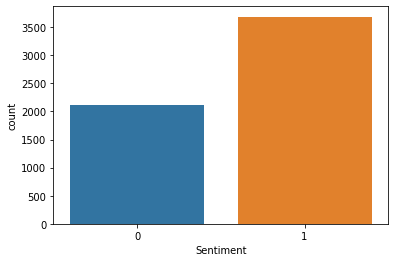

In [5]:
## Visualizing the class distribution
sns.countplot(x= stock_sentiment.Sentiment);

In [6]:
### Get data info()
stock_sentiment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5791 entries, 0 to 5790
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Text       5791 non-null   object
 1   Sentiment  5791 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.6+ KB


In [7]:
## Check for null values
stock_sentiment.isna().sum()

Text         0
Sentiment    0
dtype: int64

## Data Cleaning 

In [8]:
## Get punctuations from string 

punctuations = string.punctuation
punctuations

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

- This is the available special characters in the string class. I will utilize this and perhaps some extension to suit the need of this work if need be. However, this shall be used for the time being.

In [9]:
### Creating a function to randomly explore some values and structure of the dataset.
### The function should randomly pick a text and its correspoding sentiment 

def random_text_view(data):
  ## collect the tweets into list
  tweets = data.Text.to_list()

  ## randomly pick a text from the list
  random_text = np.random.choice(tweets)

  ## get the index of the chosen text
  index = tweets.index(random_text)

  ## get the label of the chosen text
  label = data.Sentiment.iloc[index]

  ## print conditionally
  if label == 1:
    print(f"The chosen text is------> \n{str(random_text)} \nand  it is a ------>'POSITIVE SENTIMENT'")
  else:
    print(f"The chosen text is ------> \n{str(random_text)} \nand  it is a ------> 'NEGATIVE SENTIMENT'")

## try the function
random_text_view(stock_sentiment)

The chosen text is------> 
BAC Just let digest the news with a pullback... after we should Slowly rally... 
and  it is a ------>'POSITIVE SENTIMENT'


In [10]:
#### Calling the function for multiple view of the data
for _ in range(30):
  random_text_view(stock_sentiment)

The chosen text is ------> 
So what I used to do at Borders is called showrooming...i hope this works for TGT...the nature of retail is changing   
and  it is a ------> 'NEGATIVE SENTIMENT'
The chosen text is------> 
ed Daily Triangle on HEO,.....pdating   
and  it is a ------>'POSITIVE SENTIMENT'
The chosen text is ------> 
Pre-Market osers: NFX AX ANF VXX ISG O JWN 
and  it is a ------> 'NEGATIVE SENTIMENT'
The chosen text is------> 
Equity Alpha: BAC brekaout over 11.90 resistance. Tgt  12.50. Best bank in 2013. user    
and  it is a ------>'POSITIVE SENTIMENT'
The chosen text is------> 
BAC A rally to a new stage ! 
and  it is a ------>'POSITIVE SENTIMENT'
The chosen text is ------> 
user The rare earth business fundamentals are terrible right now and MCP has all sorts of issues on top of that, compelling ?!!! 
and  it is a ------> 'NEGATIVE SENTIMENT'
The chosen text is ------> 
FS just looking more and more like a head and shoulders pattern here 
and  it is a ------> 'NEGATIVE SE

- This is quick way to check through the data and spot whether or not there may be some anomalies or wrong labeling or some special characters or some stopwords to include in the already existing stop words in the English language

In [11]:
## Removing unwanted characters. I will create functions to remove special characters and stop words

### Removing punctuation
def remove_punc(message):
  test_punc_remove = [ char  for char in message if char not in string.punctuation] ### split sentence into characters with special characters exempted.
  test_punc_remove_join = ''.join(test_punc_remove) ## Join the characters together to form the required sentence
  test_punc_remove_join = test_punc_remove_join.lower() # turn all uppercase into lowercase
  return test_punc_remove_join

### creating a new columnn on the dataframe without punctuation using the Text column
stock_sentiment['Text_without_Punctuation'] = stock_sentiment['Text'].apply(remove_punc)
stock_sentiment.head(10)

,Text,Sentiment,Text_without_Punctuation
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kickers on my watchlist xide tit soq pnk cpw b...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user aap movie 55 return for the feageed indic...
2,user I'd be afraid to short AMZN - they are lo...,1,user id be afraid to short amzn they are look...
3,MNTA Over 12.00,1,mnta over 1200
4,OI Over 21.37,1,oi over 2137
5,PGNX Over 3.04,1,pgnx over 304
6,AAP - user if so then the current downtrend wi...,0,aap user if so then the current downtrend wil...
7,Monday's relative weakness. NYX WIN TIE TAP IC...,0,mondays relative weakness nyx win tie tap ice ...
8,GOOG - ower trend line channel test & volume s...,1,goog ower trend line channel test volume sup...
9,AAP will watch tomorrow for ONG entry.,1,aap will watch tomorrow for ong entry


In [12]:
### Getting stopwords
nltk.download('stopwords')

## specifically, english stopwords
stop_words = stopwords.words('english')

### View the first 20 English stopwords
stop_words[:20]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

In [13]:
# Extending the stopwords according to the dataset
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'will', 'aap', 'co', 'day', 'user', 'stock', 'today', 'week', 'year', 'https', 'httpstco'])

In [14]:
# Removing stopwords and short words (less than 2 characters)
def text_preprocess(text):
  result = []
  for token in gensim.utils.simple_preprocess(text): ## splitting text into tokens/characters ignoring punctuations
    if token not in stop_words and len(token) >=2:
      result.append(token)
  return result

# apply pre-processing to the text column
stock_sentiment['Preprocessed_Text'] = stock_sentiment['Text_without_Punctuation'].apply(text_preprocess)
stock_sentiment.head(10)

,Text,Sentiment,Text_without_Punctuation,Preprocessed_Text
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kickers on my watchlist xide tit soq pnk cpw b...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,..."
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user aap movie 55 return for the feageed indic...,"[movie, return, feageed, indicator, trades, aw..."
2,user I'd be afraid to short AMZN - they are lo...,1,user id be afraid to short amzn they are look...,"[id, afraid, short, amzn, looking, like, nearm..."
3,MNTA Over 12.00,1,mnta over 1200,[mnta]
4,OI Over 21.37,1,oi over 2137,[oi]
5,PGNX Over 3.04,1,pgnx over 304,[pgnx]
6,AAP - user if so then the current downtrend wi...,0,aap user if so then the current downtrend wil...,"[current, downtrend, break, otherwise, shortte..."
7,Monday's relative weakness. NYX WIN TIE TAP IC...,0,mondays relative weakness nyx win tie tap ice ...,"[mondays, relative, weakness, nyx, win, tie, t..."
8,GOOG - ower trend line channel test & volume s...,1,goog ower trend line channel test volume sup...,"[goog, ower, trend, line, channel, test, volum..."
9,AAP will watch tomorrow for ONG entry.,1,aap will watch tomorrow for ong entry,"[watch, tomorrow, ong, entry]"


# Visualizing the cleaned data using `WordCloud`

- Since wordcloud prefers the dataset to be in sentence form, I will join `Proprocessed_Text` as a new column

In [15]:
stock_sentiment['Preprocessed_joined'] = stock_sentiment['Preprocessed_Text'].apply(lambda x:" ".join(x))
stock_sentiment.head(10)

,Text,Sentiment,Text_without_Punctuation,Preprocessed_Text,Preprocessed_joined
0,Kickers on my watchlist XIDE TIT SOQ PNK CPW B...,1,kickers on my watchlist xide tit soq pnk cpw b...,"[kickers, watchlist, xide, tit, soq, pnk, cpw,...",kickers watchlist xide tit soq pnk cpw bpz aj ...
1,user: AAP MOVIE. 55% return for the FEA/GEED i...,1,user aap movie 55 return for the feageed indic...,"[movie, return, feageed, indicator, trades, aw...",movie return feageed indicator trades awesome
2,user I'd be afraid to short AMZN - they are lo...,1,user id be afraid to short amzn they are look...,"[id, afraid, short, amzn, looking, like, nearm...",id afraid short amzn looking like nearmonopoly...
3,MNTA Over 12.00,1,mnta over 1200,[mnta],mnta
4,OI Over 21.37,1,oi over 2137,[oi],oi
5,PGNX Over 3.04,1,pgnx over 304,[pgnx],pgnx
6,AAP - user if so then the current downtrend wi...,0,aap user if so then the current downtrend wil...,"[current, downtrend, break, otherwise, shortte...",current downtrend break otherwise shortterm co...
7,Monday's relative weakness. NYX WIN TIE TAP IC...,0,mondays relative weakness nyx win tie tap ice ...,"[mondays, relative, weakness, nyx, win, tie, t...",mondays relative weakness nyx win tie tap ice ...
8,GOOG - ower trend line channel test & volume s...,1,goog ower trend line channel test volume sup...,"[goog, ower, trend, line, channel, test, volum...",goog ower trend line channel test volume support
9,AAP will watch tomorrow for ONG entry.,1,aap will watch tomorrow for ong entry,"[watch, tomorrow, ong, entry]",watch tomorrow ong entry


### Visualizing with wordcloud 

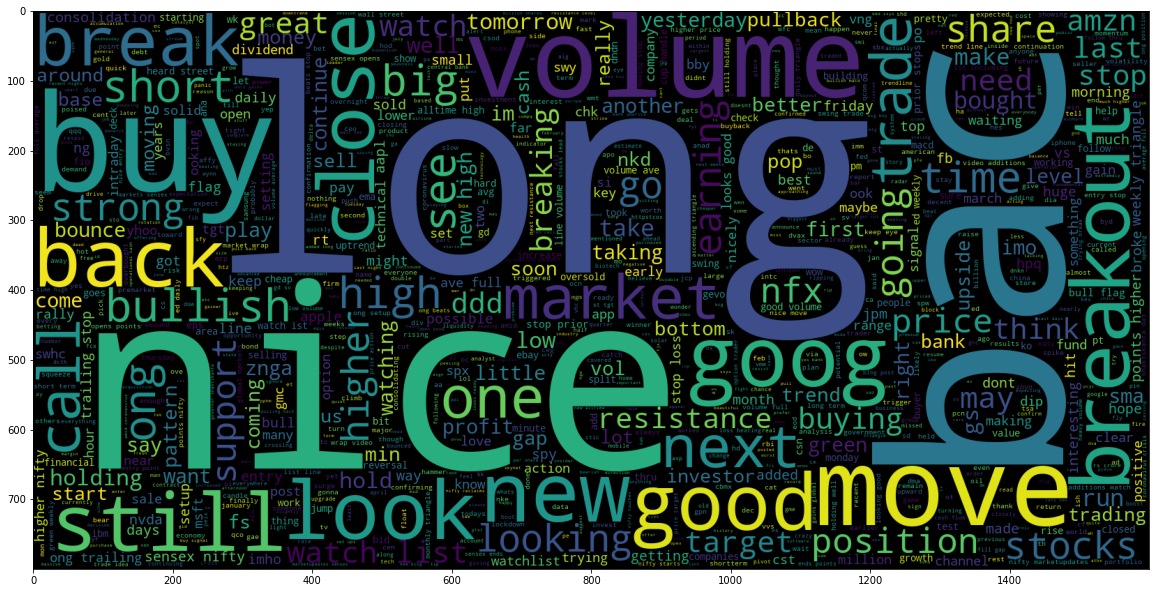

In [16]:
### Positive sentiment
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(stock_sentiment[stock_sentiment['Sentiment']==1]['Preprocessed_joined']))
plt.imshow(wc);

- Most occuring words or used words give overview about what investors are saying about the stock market. some word like `long` could mean investors are taking long positions in the options contracts, `bullish` could also mean investors are positive that the stock market is doing well.

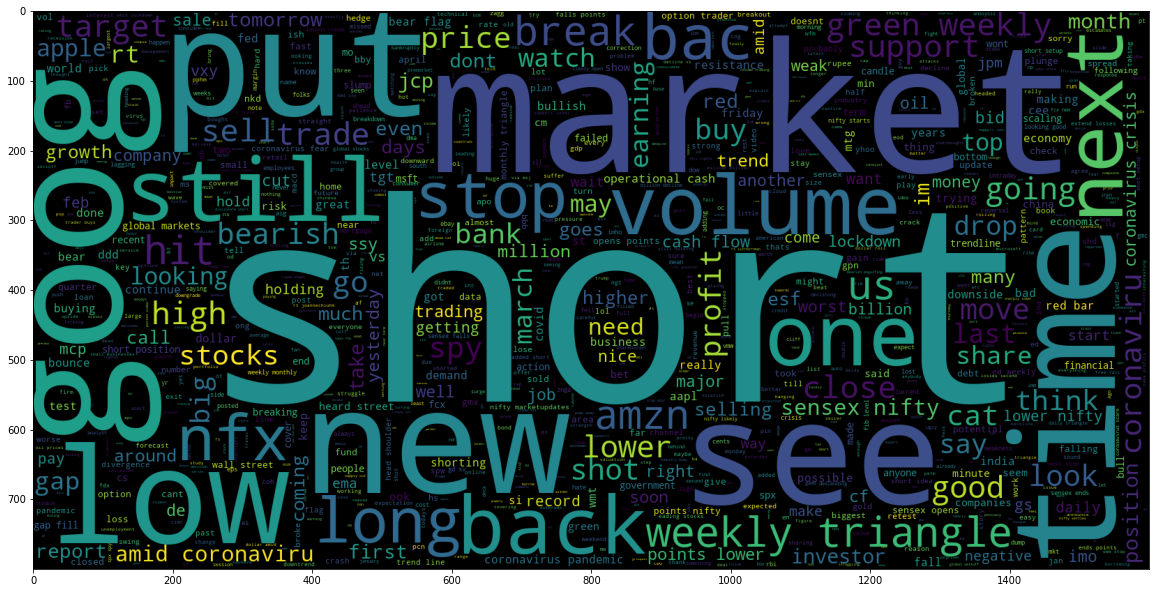

In [17]:
### Negative sentiment
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, width=1600, height=800).generate(" ".join(stock_sentiment[stock_sentiment['Sentiment']==0]['Preprocessed_joined']))
plt.imshow(wc);

- Some of the most used negative sentiments are words like `low`, `short` etc which could mean investors are taking short positions more.

In [18]:
## Getting a histogram plot for the distribution of the tokens in the dataset
tweets_length = [len(x) for x in stock_sentiment['Preprocessed_Text']]
tweets_length[:10] # view first 10

[15, 6, 8, 1, 1, 1, 8, 13, 8, 4]

In [19]:
### Plotting a histogram
fig = px.histogram(x = tweets_length,  nbins=50)
fig.show()

- Visual representation of the length of tweets in the dataset

In [20]:
### I will check for 95% percentile of the tweet length
np.percentile(np.array(tweets_length), 95)

15.0

- This means `95` percent of the tweets have length of `15`. However if I use `15` as maximum length of text, it shall take care of `95` perccent of the data.

In [21]:
### Getting total number of words in the dataset
all_words = []
for token in stock_sentiment['Preprocessed_Text']:
  for word in token:
    all_words.append(word)
len(all_words)

47529

In [22]:
### Getting the length of word in the vocabulary
vocab = list(set(all_words))
print(f"The first 10 vocabulary words are {vocab[:10]} and has a total length of {len(vocab)}")

The first 10 vocabulary words are ['uckily', 'wish', 'dismal', 'nx', 'fxs', 'penny', 'thank', 'gdp', 'bode', 'sprint'] and has a total length of 9646


In [23]:
## Global variables
LENGTH_VOCAB = len(vocab)
MAX_LEN = 15

#### Splitting data into train and test partitions

In [24]:
X = stock_sentiment['Preprocessed_Text'] ## features
y = stock_sentiment['Sentiment'] ## target

## Using sklearn's train_test_split with 80% for training and 20% for test and validation
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4632,), (1159,), (4632,), (1159,))

## Text to Sequence

In [25]:
## instantiate the tokenizer with number of vocab defined
tokenizer = Tokenizer(num_words = LENGTH_VOCAB)
## fit the tokenizer
tokenizer.fit_on_texts(X_train)


## Generate sequence for train data
train_sequence = tokenizer.texts_to_sequences(X_train)

## Generate sequence for test data
test_sequences = tokenizer.texts_to_sequences(X_test)

In [26]:
## View sample of the train data before text_to_sequence
X_train[:20]

4201    [ove, gnw, calls, making, feel, better, dumpin...
387     [csn, option, trader, buys, jan, call, spread,...
4385    [people, slag, cannibalization, samsung, phone...
5773    [sensex, opens, points, lower, nifty, starts, ...
2348    [csod, conf, call, ceo, feeling, good, positio...
1557                                        [csn, buying]
4619    [ms, ready, crack, technicals, read, bearish, ...
2778                          [meanwhile, decaying, swhc]
2117                                 [volume, fade, fast]
2960          [next, resistance, trendline, go, aapl, go]
1410        [gpn, inverted, head, shoulders, still, play]
3560    [equity, alpha, infa, fav, short, opp, growth,...
677                              [sending, reminder, nok]
4374    [continues, show, signs, breaking, downtrend, ...
5639    [government, may, unveil, rs, lakh, crore, pac...
5619    [banks, atms, remain, open, nirmala, sitharama...
61      [analyst, price, targets, earnings, targets, c...
1835        [p

In [27]:
## View sample of train data after text_to_sequence
train_sequence[:20]

[[604, 2428, 76, 203, 1075, 165, 1259, 1850],
 [353,
  152,
  488,
  336,
  269,
  105,
  660,
  55,
  270,
  1851,
  2429,
  57,
  354,
  320,
  3572,
  269],
 [286, 3573, 3574, 489, 1852, 2430, 2431, 7, 1483, 2432],
 [23, 271, 46, 41, 31, 380, 24, 250, 106, 23, 31, 407],
 [739, 3575, 105, 570, 1260, 5, 57, 5, 490, 95, 48],
 [353, 73],
 [355, 204, 1076, 530, 661, 133, 69, 3, 817, 116],
 [3576, 3577, 356],
 [2, 818, 287],
 [15, 66, 357, 38, 153, 38],
 [260, 2433, 358, 662, 12, 140],
 [663, 819, 3578, 1853, 1, 1484, 141, 49, 820, 1],
 [2434, 1854, 1261],
 [251, 531, 740, 77, 571, 14, 30, 1],
 [337, 56, 3579, 272, 925, 408, 1262, 3580, 18, 3581, 219, 3582, 3583],
 [224,
  3584,
  1077,
  112,
  1485,
  1855,
  3585,
  219,
  1263,
  465,
  1078,
  2435,
  2436,
  3586],
 [1079, 50, 741, 53, 741, 95, 3587, 205, 22, 338, 1856],
 [1857, 33, 2437, 20, 442, 821],
 [3588, 67, 664, 133, 3589, 1, 3590, 3591, 3592, 1080, 926, 822, 665, 927],
 [1264, 3593, 2438, 30]]

### Padding sequences to have the same length of sequences

In [28]:
# Add padding to training and testing
padded_train = pad_sequences(train_sequence, maxlen=MAX_LEN, padding='post')
padded_test = pad_sequences(test_sequences, maxlen=MAX_LEN, padding='post')


### view sample of the padded sequence
for i, doc in enumerate(padded_train[:3]):
  print('The padded encoding for document: ', i+1, 'is', doc)

The padded encoding for document:  1 is [ 604 2428   76  203 1075  165 1259 1850    0    0    0    0    0    0
    0]
The padded encoding for document:  2 is [ 152  488  336  269  105  660   55  270 1851 2429   57  354  320 3572
  269]
The padded encoding for document:  3 is [ 286 3573 3574  489 1852 2430 2431    7 1483 2432    0    0    0    0
    0]


In [29]:
# Convert the target to categorical 2D representation
y_train_cat = to_categorical(y_train, 2)
y_test_cat = to_categorical(y_test, 2)

### printing first 10 sample of the categorical representation 
print(f"This is how the categorical representation looks like: \n{y_train_cat[:10]} \nshape: \n{y_train_cat.shape}")

This is how the categorical representation looks like: 
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]] 
shape: 
(4632, 2)


In [30]:
### Creating an embedding layer for the text representation
token_embed = tf.keras.layers.Embedding(input_dim=LENGTH_VOCAB, # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding") 

In [31]:
### view an example embedding for the one of the sequences
print(f"Word embedding for the first item in padded train is \n{token_embed(padded_train[0])} \nshape is \n{token_embed(padded_train[0]).shape}")

Word embedding for the first item in padded train is 
[[ 0.00982613 -0.04541855 -0.03099296 ...  0.02824095 -0.00619937
  -0.0204697 ]
 [ 0.01410179  0.04075487 -0.01136806 ... -0.04433092  0.00090996
  -0.01361874]
 [-0.01713233  0.01530572 -0.01875942 ...  0.00523384 -0.01462664
  -0.02454562]
 ...
 [-0.02841228 -0.02886454  0.03276021 ... -0.00416565 -0.02281243
   0.04651096]
 [-0.02841228 -0.02886454  0.03276021 ... -0.00416565 -0.02281243
   0.04651096]
 [-0.02841228 -0.02886454  0.03276021 ... -0.00416565 -0.02281243
   0.04651096]] 
shape is 
(15, 128)


### Creating datasets using TensorFlow Datasets

In [32]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((padded_train, y_train_cat))
test_dataset = tf.data.Dataset.from_tensor_slices((padded_test, y_test_cat))

# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

## view how the dataset looks like now.
train_dataset

<PrefetchDataset shapes: ((None, 15), (None, 2)), types: (tf.int32, tf.float32)>

### Building first model with `Conv1D`

> ##### Create 1D convolutional model to process sequences


In [33]:
## define the number of classes
num_classes = len(np.unique(y_train_cat))

### create the inputs
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))

## add the embedding layer
token_embeddings = token_embed(inputs) # create embedding
x = tf.keras.layers.Conv1D(32, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = tf.keras.layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(x)
x = tf.keras.layers.Conv1D(128, kernel_size=5, padding="same", activation="relu")(x)

## Add a pooling layer
x = tf.keras.layers.GlobalAveragePooling1D()(x)

### create the output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

## create the model
model_conv1d = tf.keras.Model(inputs, outputs)

# Compile the model
model_conv1d.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [34]:
### Model summary
model_conv1d.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
token_embedding (Embedding)  (None, 15, 128)           1234688   
_________________________________________________________________
conv1d (Conv1D)              (None, 15, 32)            20512     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 15, 64)            10304     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 15, 128)           41088     
_________________________________________________________________
global_average_pooling1d (Gl (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 2)                 258   

In [35]:
# Fit the model
model_conv1d_history = model_conv1d.fit(train_dataset,
                              steps_per_epoch=int(0.20 * len(train_dataset)), # only fit on 20% of batches for faster training time
                              epochs=5,
                              validation_data=test_dataset,
                              validation_steps=int(0.20 * len(test_dataset))) # only validate on 20% of batches

Epoch 1/5
29/29 [==============================] - 32s 21ms/step - loss: 0.6685 - accuracy: 0.6261 - val_loss: 0.6580 - val_accuracy: 0.6384
Epoch 2/5
29/29 [==============================] - 0s 14ms/step - loss: 0.6511 - accuracy: 0.6272 - val_loss: 0.6422 - val_accuracy: 0.6384
Epoch 3/5
29/29 [==============================] - 0s 15ms/step - loss: 0.6117 - accuracy: 0.6444 - val_loss: 0.5523 - val_accuracy: 0.7411
Epoch 4/5
29/29 [==============================] - 0s 15ms/step - loss: 0.5489 - accuracy: 0.7209 - val_loss: 0.5215 - val_accuracy: 0.7321
Epoch 5/5
29/29 [==============================] - 1s 18ms/step - loss: 0.5134 - accuracy: 0.7478 - val_loss: 0.4989 - val_accuracy: 0.7679


## Function to visualize training history

In [36]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

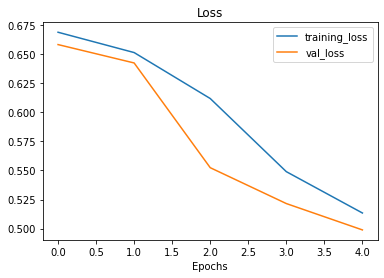

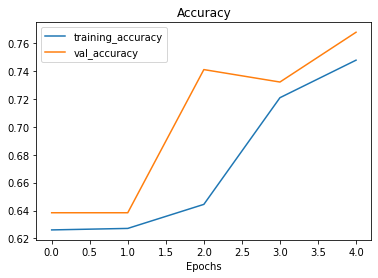

In [37]:
# Visualize the training
plot_loss_curves(model_conv1d_history)

In [38]:
# Evaluate on whole validation dataset (I only validated on 20% of batches during training)
model_conv1d.evaluate(test_dataset)

37/37 [==============================] - 0s 4ms/step - loss: 0.4678 - accuracy: 0.7886


[0.4678216278553009, 0.7886108756065369]

> Since it's a classification problem with one class more distributed than the other, evaluating the preformance with only accuracy wouldn't a good practice. Hence, I shall consider precision, recall and f1_score as metrics as well. And for the benefit of handy experiments, I think it's best to functionalize my metric performance for models I will be using here.

In [39]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
      y_true: true labels in the form of a 1D array
      y_pred: predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results

In [40]:
# Make predictions (the model outputs prediction probabilities for each class)
model_conv1d_pred_probs = model_conv1d.predict(test_dataset)
model_conv1d_pred_probs

array([[0.34694615, 0.6530538 ],
       [0.6785015 , 0.3214985 ],
       [0.05560252, 0.9443975 ],
       ...,
       [0.07085499, 0.929145  ],
       [0.7885404 , 0.21145964],
       [0.3649987 , 0.6350013 ]], dtype=float32)

In [41]:
# Convert pred probs to classes
model_conv1d_preds = tf.argmax(model_conv1d_pred_probs, axis=1)
model_conv1d_preds

<tf.Tensor: shape=(1159,), dtype=int64, numpy=array([1, 0, 1, ..., 1, 0, 1])>

In [42]:
# Calculating the results for Conv1D model
model_conv1d_results = calculate_results(y_test, model_conv1d_preds)
model_conv1d_results

{'accuracy': 78.86108714408974,
 'f1': 0.7847083029136525,
 'precision': 0.7855357182363222,
 'recall': 0.7886108714408974}

## Model 2- LSTM layers

In [43]:
### create the inputs
inputs = tf.keras.layers.Input(shape=15)

## add the embedding layer
token_embeddings = token_embed(inputs) 
x = tf.keras.layers.LSTM(256)(token_embeddings)

## Add a pooling layer
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)

### create the output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

## create the model
model_lstm = tf.keras.Model(inputs, outputs)

# Compile the model
model_lstm.compile(loss="categorical_crossentropy", 
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [44]:
## Check model summary 
model_lstm.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 15)]              0         
_________________________________________________________________
token_embedding (Embedding)  (None, 15, 128)           1234688   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 258       
Total params: 1,662,082
Trainable params: 1,662,082
Non-trainable params: 0
_________________________________________________

In [45]:
# Fit the model
model_lstm_history = model_lstm.fit(train_dataset,
                              steps_per_epoch=int(0.20 * len(train_dataset)), # only fit on 20% of batches for faster training time
                              epochs=3,
                              validation_data=test_dataset,
                              validation_steps=int(0.20 * len(test_dataset))) # only validate on 20% of batches

Epoch 1/3
29/29 [==============================] - 7s 62ms/step - loss: 0.5123 - accuracy: 0.7726 - val_loss: 0.4857 - val_accuracy: 0.7589
Epoch 2/3
29/29 [==============================] - 1s 21ms/step - loss: 0.3737 - accuracy: 0.8427 - val_loss: 0.4820 - val_accuracy: 0.7679
Epoch 3/3
29/29 [==============================] - 1s 22ms/step - loss: 0.2866 - accuracy: 0.8793 - val_loss: 0.5065 - val_accuracy: 0.7902


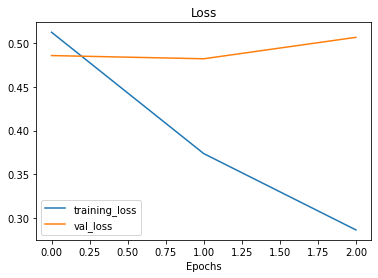

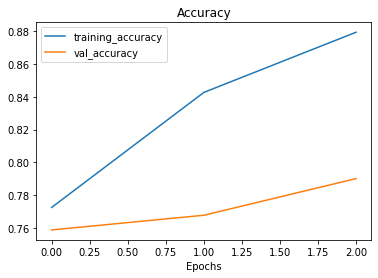

In [46]:
# Visualize the training
plot_loss_curves(model_lstm_history)

- The training seems to overfit. A few tips here is that, I could change the LSTM acrhitecture for the model to better generalize or also train the model for just one epoch which may be a good generalization.

In [47]:
# Evaluate on whole validation dataset (I only validated on 20% of batches during training)
model_lstm.evaluate(test_dataset)

37/37 [==============================] - 0s 4ms/step - loss: 0.5080 - accuracy: 0.7843


[0.5080147385597229, 0.7842968106269836]

In [48]:
# Make predictions (the model outputs prediction probabilities for each class)
model_lstm_pred_probs = model_lstm.predict(test_dataset)
model_lstm_pred_probs

array([[0.16754176, 0.8324582 ],
       [0.35688078, 0.6431192 ],
       [0.00121353, 0.9987865 ],
       ...,
       [0.01365399, 0.98634607],
       [0.96099466, 0.03900535],
       [0.42898208, 0.5710179 ]], dtype=float32)

In [49]:
# Convert pred probs to classes
model_lstm_pred = tf.argmax(model_lstm_pred_probs, axis=1)
model_lstm_pred

<tf.Tensor: shape=(1159,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 0, 1])>

In [50]:
# Calculating the results for LSTM model
model_lstm_results = calculate_results(y_test, model_lstm_pred)
model_lstm_results

{'accuracy': 78.42968075927523,
 'f1': 0.7818653683715274,
 'precision': 0.7814152201808292,
 'recall': 0.7842968075927523}

## Model 3: Feature extraction with pretrained token embeddings

- Create pretrained word embedding layer using TensorFlow Hub

In [51]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False, ## set the layer to untrainable mode
                                        name="universal_sentence_encoder") # I am using the Universal Sentence encoder pretrained model from tensorflow hub

### The pretrained model takes in list of sentences, hence I will prepare the dataset using the sentences

In [52]:
X_sentences = stock_sentiment['Preprocessed_joined']
y_labels = stock_sentiment['Sentiment']

X_train_sentences, X_test_sentences, y_train_labels, y_test_labels = train_test_split(X_sentences, y_labels, test_size = 0.20, random_state = 42)

## coonfirm shapes
len(X_train_sentences), len(X_test_sentences), len(y_train_labels), len(y_test_labels)

(4632, 1159, 4632, 1159)

In [53]:
# Convert the target to categorical 2D representation
y_train_pretrained = to_categorical(y_train_labels, 2)
y_test_pretrained = to_categorical(y_test_labels, 2)

> # Preparing train sentences

In [54]:
# Turn our data into TensorFlow Datasets
train_dataset_pretrain = tf.data.Dataset.from_tensor_slices((X_train_sentences, y_train_pretrained))
test_dataset_pretrain = tf.data.Dataset.from_tensor_slices((X_test_sentences, y_test_pretrained))

# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset_pretrain = train_dataset_pretrain.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset_pretrain = test_dataset_pretrain.batch(32).prefetch(tf.data.AUTOTUNE)

## view how the dataset looks like now.
train_dataset_pretrain

<PrefetchDataset shapes: ((None,), (None, 2)), types: (tf.string, tf.float32)>

In [55]:
## Sample embedding for one sentence from the training dataset
tf_hub_embedding_layer([X_train_sentences[0]])

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 0.00211701, -0.04924205,  0.0021612 , -0.00531042, -0.05128931,
         0.06322286, -0.01551419, -0.01002992, -0.07092448,  0.04083443,
        -0.02874597,  0.01757369, -0.01544616, -0.03088231,  0.02400426,
         0.06563162,  0.02690543, -0.0121691 , -0.06808415, -0.01285926,
        -0.03458952,  0.02306759, -0.04473584,  0.02815449, -0.05403021,
        -0.00453177,  0.0459577 , -0.01844555, -0.05296564,  0.07086609,
         0.03836862, -0.01969877, -0.00410512, -0.06308177,  0.04236171,
        -0.04140837, -0.04519807,  0.00056018,  0.0228328 ,  0.0156563 ,
         0.0300372 ,  0.03403239,  0.03901521,  0.04281057, -0.00551596,
         0.01548204,  0.07192788, -0.01027901, -0.03511031,  0.03186408,
         0.06806558, -0.00451835, -0.08580994, -0.05017463,  0.06408478,
         0.02469626,  0.08317924, -0.01075645,  0.02797419,  0.00637349,
         0.06259056,  0.03045239, -0.03676453,  0.06071986,  0.0159301 ,
 

- Building a feature extraction model 

In [56]:
# Define input shape for the model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

#create embedding with the pretrained model
pretrained_embedding = tf_hub_embedding_layer(inputs) 

# add a fully connected layer on top of the embedding
x = tf.keras.layers.Dense(128, activation="relu")(pretrained_embedding)

# create the output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

## create model
feature_extract_model = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
feature_extract_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [57]:
## Check model summary
feature_extract_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder ( (None, 512)               256797824 
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 256,863,746
Trainable params: 65,922
Non-trainable params: 256,797,824
_________________________________________________________________


In [58]:
# Fit the model
feature_extract_model_history = feature_extract_model.fit(train_dataset_pretrain,
                                                          steps_per_epoch=int(0.20 * len(train_dataset_pretrain)), # only fit on 20% of batches for faster training time
                                                          epochs=3,
                                                          validation_data=test_dataset_pretrain,
                                                          validation_steps=int(0.20 * len(test_dataset_pretrain))) # only validate on 20% of batches

Epoch 1/3
29/29 [==============================] - 3s 25ms/step - loss: 0.6642 - accuracy: 0.6196 - val_loss: 0.6375 - val_accuracy: 0.6384
Epoch 2/3
29/29 [==============================] - 0s 11ms/step - loss: 0.6266 - accuracy: 0.6455 - val_loss: 0.6108 - val_accuracy: 0.6696
Epoch 3/3
29/29 [==============================] - 0s 10ms/step - loss: 0.5896 - accuracy: 0.6961 - val_loss: 0.5839 - val_accuracy: 0.7009


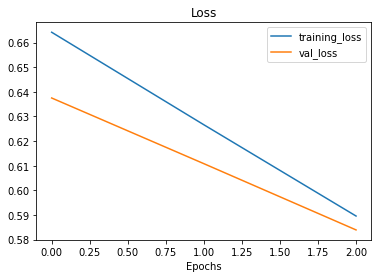

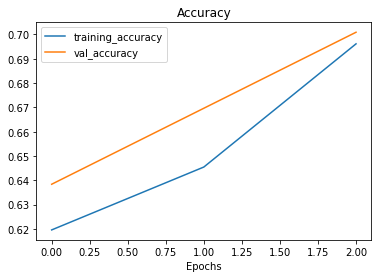

In [59]:
# Visualize the training
plot_loss_curves(feature_extract_model_history)

In [60]:
# Evaluate on whole validation dataset (I only validated on 20% of batches during training)
feature_extract_model.evaluate(test_dataset_pretrain)

37/37 [==============================] - 0s 9ms/step - loss: 0.5841 - accuracy: 0.6997


[0.5840818881988525, 0.6997411847114563]

In [61]:
# Make predictions (the model outputs prediction probabilities for each class)
model_feature_extract_pred_probs = feature_extract_model.predict(test_dataset_pretrain)
model_feature_extract_pred_probs

array([[0.24643518, 0.7535648 ],
       [0.3050525 , 0.69494754],
       [0.40550146, 0.5944985 ],
       ...,
       [0.31448773, 0.68551224],
       [0.45818695, 0.5418131 ],
       [0.28377476, 0.71622527]], dtype=float32)

In [62]:
# Convert pred probs to classes
model_feature_extract_pred = tf.argmax(model_feature_extract_pred_probs, axis=1)
model_feature_extract_pred

<tf.Tensor: shape=(1159,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 1, 1])>

In [63]:
# Calculating the results for the model
model_feature_extract_results = calculate_results(y_test_labels, model_feature_extract_pred)
model_feature_extract_results

{'accuracy': 69.97411561691112,
 'f1': 0.6627300277185861,
 'precision': 0.702011615522196,
 'recall': 0.6997411561691113}

- The feature extraction model is so far the worse performing. Maybe I will consider setting the embedding to train and compare performance.

In [64]:
### Setting the embedding layer to trainable

# Download pretrained TensorFlow Hub USE
tf_hub_embedding_layer_trainable = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=True, ## set the layer to trainable mode
                                        name="universal_sentence_encoder_trainable") # I am using the Universal Sentence encoder pretrained model from tensorflow hub

### Rebuilding the  model

In [65]:
# Define input shape for the model
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

#create embedding with the pretrained model
pretrained_embedding = tf_hub_embedding_layer_trainable(inputs) 

# add a fully connected layer on top of the embedding
x = tf.keras.layers.Dense(128, activation="relu")(pretrained_embedding)

# create the output layer
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

## create model
trainable_embedding_model = tf.keras.Model(inputs=inputs,
                        outputs=outputs)

# Compile the model
trainable_embedding_model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [66]:
# check summary of the model and the trainable parameters
trainable_embedding_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None,)]                 0         
_________________________________________________________________
universal_sentence_encoder_t (None, 512)               256797824 
_________________________________________________________________
dense_5 (Dense)              (None, 128)               65664     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 256,863,746
Trainable params: 256,863,746
Non-trainable params: 0
_________________________________________________________________


- Waaoo!!! A lot of paramters to train here!

In [67]:
# Fit the model
trainable_embedding_model_history = trainable_embedding_model.fit(train_dataset_pretrain,
                                                          steps_per_epoch=int(0.20 * len(train_dataset_pretrain)), # only fit on 20% of batches for faster training time
                                                          epochs=5,
                                                          validation_data=test_dataset_pretrain,
                                                          validation_steps=int(0.20 * len(test_dataset_pretrain))) # only validate on 20% of batches

Epoch 1/5
29/29 [==============================] - 10s 166ms/step - loss: 0.6547 - accuracy: 0.6293 - val_loss: 0.6431 - val_accuracy: 0.6562
Epoch 2/5
29/29 [==============================] - 4s 152ms/step - loss: 0.6165 - accuracy: 0.6659 - val_loss: 0.5871 - val_accuracy: 0.6741
Epoch 3/5
29/29 [==============================] - 4s 152ms/step - loss: 0.5709 - accuracy: 0.6961 - val_loss: 0.5504 - val_accuracy: 0.6696
Epoch 4/5
29/29 [==============================] - 4s 153ms/step - loss: 0.5273 - accuracy: 0.7317 - val_loss: 0.5404 - val_accuracy: 0.6964
Epoch 5/5
29/29 [==============================] - 4s 154ms/step - loss: 0.4985 - accuracy: 0.7446 - val_loss: 0.5073 - val_accuracy: 0.7366


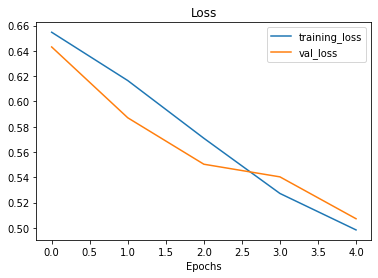

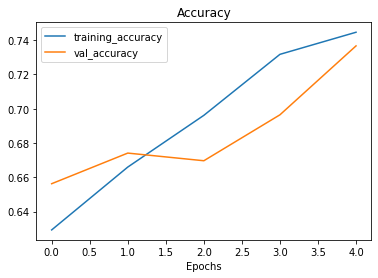

In [68]:
# Visualize the training
plot_loss_curves(trainable_embedding_model_history)

In [69]:
# Evaluate on whole validation dataset (I only validated on 20% of batches during training)
trainable_embedding_model.evaluate(test_dataset_pretrain)

37/37 [==============================] - 0s 9ms/step - loss: 0.4850 - accuracy: 0.7696


[0.48498231172561646, 0.7696290016174316]

In [70]:
# Make predictions (the model outputs prediction probabilities for each class)
trainable_embedding_pred_probs = trainable_embedding_model.predict(test_dataset_pretrain)
trainable_embedding_pred_probs

array([[0.16059437, 0.83940566],
       [0.21595252, 0.7840475 ],
       [0.1952775 , 0.8047225 ],
       ...,
       [0.25121957, 0.7487804 ],
       [0.8367732 , 0.16322674],
       [0.21346763, 0.78653234]], dtype=float32)

In [71]:
# Convert pred probs to classes
trainable_embedding_pred = tf.argmax(trainable_embedding_pred_probs, axis=1)
trainable_embedding_pred

<tf.Tensor: shape=(1159,), dtype=int64, numpy=array([1, 1, 1, ..., 1, 0, 1])>

In [72]:
# Calculating the results for the model
trainable_embedding_results = calculate_results(y_test_labels, trainable_embedding_pred)
trainable_embedding_results

{'accuracy': 76.96289905090595,
 'f1': 0.7652071744463651,
 'precision': 0.76567871056451,
 'recall': 0.7696289905090595}

### Creating a DataFrame for all experiments carried out and the best model performance

In [73]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"Conv1D Model": model_conv1d_results,
                                  "LSTM Model": model_lstm_results,
                                  "pretrained_untraining_embed": model_feature_extract_results,
                                  "pretrained_trainable_embed": trainable_embedding_results,
                                  })
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
Conv1D Model,78.861087,0.785536,0.788611,0.784708
LSTM Model,78.429681,0.781415,0.784297,0.781865
pretrained_untraining_embed,69.974116,0.702012,0.699741,0.662730
pretrained_trainable_embed,76.962899,0.765679,0.769629,0.765207


In [74]:
# Reduce the accuracy to same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
Conv1D Model,0.788611,0.785536,0.788611,0.784708
LSTM Model,0.784297,0.781415,0.784297,0.781865
pretrained_untraining_embed,0.699741,0.702012,0.699741,0.662730
pretrained_trainable_embed,0.769629,0.765679,0.769629,0.765207


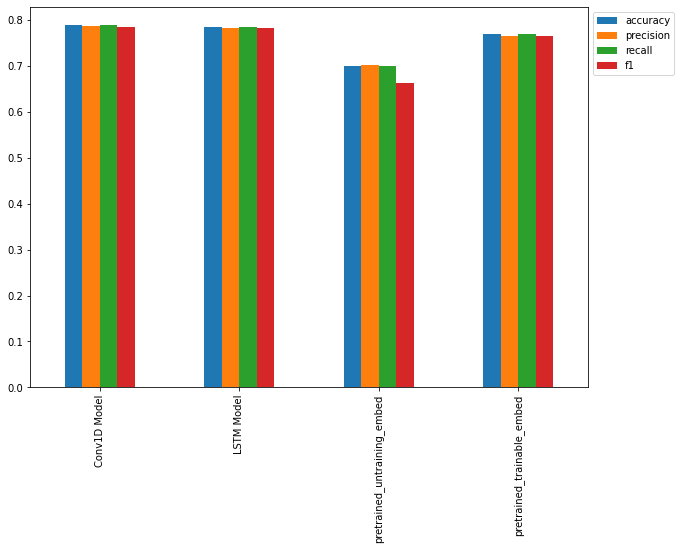

In [75]:
# Plot and compare all of the model results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));

- By far, my worse performing model is the feature_extract_model, whereas Conv1D, LSTM and pretrained_embedding models seem to have almost the same performance.
- Since this is a classification problem, I will generalize on the performance metrics using f1_score as the best metrics to choosing the right model. However, there are a few twerks that could have given more performance to pretrained model, thus, perhaps, an increase in the number of epochs would have enhance the performance a bit.


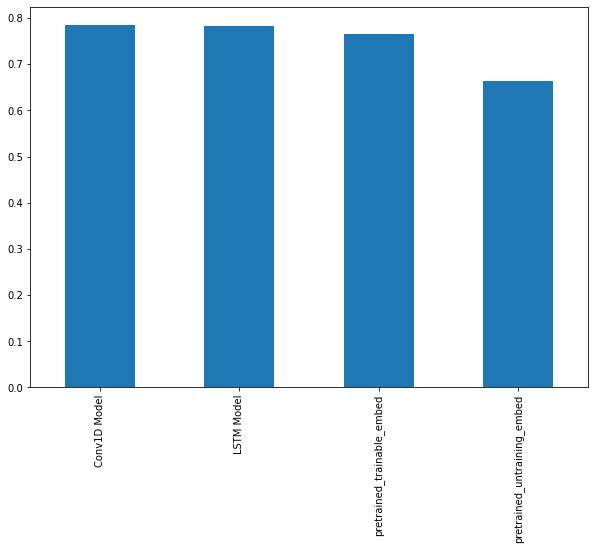

In [76]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

 - By this visual, my conclusion is that the Conv1D has the highest performance for the `f1_score` and therefore, I could use the trainable embeddings with the Conv1D layers which I think would increase the performance. This shall be in the a future work. You can feel free to give it a try as well.